In [1]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

import pandas as pd
import imageio
from IPython.display import clear_output

import sys
import os

simulacion = 7

## Generacion del tablero

In [2]:
def generarTablero( cantCeldas, habitantes ):

    """
    Genero un tablero de cantCeldas x cantCeldas    
    """

    tableroInicial = []
    tableroConLetras = []

    for i in range(0,cantCeldas):
        linea = np.random.rand(cantCeldas)
        tableroInicial.append(linea)
        tableroConLetras.append([0 for x in range(0,cantCeldas)])

    print("Tablero generado de : " + str(len(tableroInicial)) + " x " + str(len(tableroInicial[0])))

    return inicializarTablero( tableroInicial, tableroConLetras, habitantes )



def inicializarTablero(t, tablero, habitantes):
    """
    Inicializo un tablero de cantCeldas x cantCeldas con valores entre [0,1]
    
    Devuelve un array de cantCeldas x cantCeldas con la representacion de personas [X,A,B,C]
    """

    pHabitantes = habitantes/(len(t)*len(t))

    pContagiados = 0.03*pHabitantes

    habitantesGenerados = 0
    habitantesGeneradosContagiados = 0

    for i in range(0,len(tablero)):

        for j in range(0,len(tablero[i])):

            x = t[i][j]

            if x <= pContagiados:
                tablero[i][j] = "X0"
                habitantesGeneradosContagiados += 1

            elif x <= pHabitantes:
                y = np.random.rand(1)
                habitantesGenerados += 1

                if y <= 0.7:
                    tablero[i][j] = "A"
                elif y <= 0.9:
                    tablero[i][j] = "B"
                else:
                    tablero[i][j] = "C"
                
            else:
                tablero[i][j] = "-"

    print("Cantidad de celdas: " + str(cant_celdas*cant_celdas))
    print("Habitantes generados: " + str(habitantesGenerados))
    print("Habitantes generados contagiados: " + str(habitantesGeneradosContagiados)) 
    print("Porcentaje inicia de poblacion contagiada: " + str(habitantesGeneradosContagiados/habitantesGenerados) )
    print("--------------------------------")
    
    return tablero

## Vemos como quedaria el mapa 

Donde:

Xi - Contagiados durante i periodos de tiempo

R - Persona recuperada

A - Habitante de tipo A

B - Habitante de tipo B

C - Habitante de tipo C



In [3]:
metros = 100
tamaño_celda = 0.4

cant_celdas = int( metros/tamaño_celda )

habitantes = 10000

mapa = generarTablero( cant_celdas, habitantes )

df = pd.DataFrame(data=mapa)

frequencies = {}
for item in df.values.ravel():
    if item in frequencies:
        frequencies[item] += 1
    else:
        frequencies[item] = 1

print("Cantidad de personas en el mapa: ")
print(frequencies)

print("--------------------------------\n")

print(df)

Tablero generado de : 250 x 250
Cantidad de celdas: 62500
Habitantes generados: 9734
Habitantes generados contagiados: 305
Porcentaje inicia de poblacion contagiada: 0.03133347031025272
--------------------------------
Cantidad de personas en el mapa: 
{'A': 6751, '-': 52461, 'B': 1990, 'C': 993, 'X0': 305}
--------------------------------

    0   1   2   3   4   5   6   7   8   9    ... 240 241 242 243 244 245 246  \
0     A   -   -   -   A   -   -   -   -   -  ...   -   -   -   A   -   -   -   
1     -   -   -   -   -   C   -   -   -   -  ...   A   A   -   -   -   -   -   
2     -   -   A   -   -   -   -   -   -   -  ...   -   -   -   -   -   -   -   
3     -   -   -   A   -   -   -   -   -   -  ...   C   -   -   -   -   -   A   
4     -   -   B   -   -   A   A   -   -   -  ...   -   C   -   -   -   A   -   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
245   -   -   -   -   -   -   -   -   -   A  ...   -   -   -   -   -   -   -   
246   -   -   -  

## Movimiento por iteraciones

In [22]:
def randomWalk(r):
    """Dado un numero random entre [0,1] devuelvo una tupla con valores"""
    if r < 0.25:
        return (0,1)
    if r < 0.5:
        return (1,0)
    if r < 0.75:
        return (-1,0)
    else:
        return (0,-1)


def moverPersonas( tablero, seMueveB, seMueveC, medidasGovierno, recuperacion, pRecuperacion, pInmunizar ):
    """Recorro el tablero moviendo a las personas de manera random y buscando las zonas de contagio"""    
    for i in range(0,len(tablero)):
        for j in range(0,len(tablero[i])):

            r = np.random.random()

            if tablero[i][j] == "A":
                movimiento = randomWalk(r)
                reemplazar(tablero, i, j, movimiento, "A")

            elif seMueveB and tablero[i][j] == "B":
                movimiento = randomWalk(r)
                reemplazar(tablero, i, j, movimiento, "B")

            elif seMueveC and tablero[i][j] == "C":
                movimiento = randomWalk(r)
                reemplazar(tablero, i, j, movimiento, "C")

            elif tablero[i][j][0] == 'X':

                instante = int( tablero[i][j][1:] )

                if instante >= 0:
                    contagiarPersonas( tablero, i, j, medidasGovierno )

                instante += 1

                tablero[i][j] = "X"+ str(instante)
                
                if instante >= recuperacion:                    
                    if r < pRecuperacion:
                        darDeAlta( tablero, i, j, pInmunizar )
    

def verificarMovimiento( t, i, j, movimiento ):
    """Checkeo que no haya nadie en la pos a mover"""
    x = i + movimiento[0]
    y = j + movimiento[1]

    if x < 0 or x >= 250 or y < 0 or y >= 250:
        return False

    if t[x][y] == "-" :
        return True

    return False


def reemplazar( t, i, j, movimiento, caracter ):
    """Reemplazo a un lugar vacio por una persona"""
    x = i + movimiento[0]
    y = j + movimiento[1]

    if verificarMovimiento( t, i, j, movimiento ):    
        t[i][j] = "-"
        t[x][y] = caracter
        return (x,y)    
    return (i,j)


## Contagios

In [23]:
def darDeAlta( t, i, j, pNoVolverseAContagiar ):
    r = np.random.random()

    if r < pNoVolverseAContagiar:
        t[i][j] = "R"
    else:
        t[i][j] = np.random.choice(["A","B","C"],p=[0.7, 0.2, 0.1])

def contagiarPersonas( t, x, y, medidasGovierno ):
    """ Si hay alguien contagiado busco las 5 casillas al rededor y veo si contagio a esa persona """
    for i in range(-4,5):
        
        if (x+i < 0 or x+i >= 250):
            continue

        for j in range(-4,5):
         
            if (i == 0 and j == 0) or y+j < 0 or y+j >=250:
                continue
         
            if t[x+i][y+j] in ["A","B","C"]:
                r = np.random.random()
                if r < (0.65 - medidasGovierno):
                    contagiar( t, x+i, y+j )



def contagiar( tablero, x, y ):
    tablero[x][y] = "X-1"


## Realizacion de conteo

In [24]:
def realizarConteo(tablero):
    habitantesSanos = 0
    habitantesContagiados = 0
    habitantesRecuperados = 0

    df = pd.DataFrame(data=mapa)

    frequencies = {}
    for item in df.values.ravel():
        if item in frequencies:
            frequencies[item] += 1
        else:
            frequencies[item] = 1
    
    for key, value in frequencies.items():
        if key in ["A","B","C"]:
            habitantesSanos += value
        elif "X" in key:
            habitantesContagiados += value
        elif key == "R":
            habitantesRecuperados = value


    habitantes = habitantesSanos+habitantesContagiados+habitantesRecuperados
            
    print("Habitantes: " + str(habitantes) )
    print("Habitantes sanos: " + str(habitantesSanos) )
    print("Habitantes contagiados: " + str(habitantesContagiados) )
    print("Habitantes inmunizados: " + str(habitantesRecuperados) )
    print("----------------------------")
    print("Porcentaje de poblacion sana: " + str(habitantesSanos/habitantes) )
    print("Porcentaje de poblacion contagiada: " + str(habitantesContagiados/habitantes) )
    print("Porcentaje de poblacion inmunizados: " + str(habitantesRecuperados/habitantes) )
    return ( habitantesSanos, habitantesContagiados, habitantesRecuperados, habitantesSanos+habitantesRecuperados )


## Graficos

In [25]:
def plotHeatmapAnimation( datas, i ):
    
    df = datas[i]

    plt.figure(figsize=(15, 8))

    values = sorted(pd.unique(df.values.ravel()))

    value_to_int = {j:i for i,j in enumerate(values)}
   
    n = 1    
    colors = ["black"]
    
    if 'Poblacion sana' in values:
        colors.append("limegreen")   
        n += 1

    if 'Pobracion contagiada' in values:
        colors.append("red")
        n += 1

    if 'Pobracion inmunizada' in values:
        colors.append("blueviolet")
        n += 1

    cmap = sns.color_palette( tuple(colors), n)
        
    ax = sns.heatmap(df.replace(value_to_int), cmap=cmap) 

    # modify colorbar:
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks( [colorbar.vmin + r / n * (0.5 + i) for i in range(n)] )
    colorbar.set_ticklabels( values )   

    ax.set_title('Mapa en el momento: ' + str(i) )   
    ax.set(yticks=[],xticks=[])

    plt.savefig(str(simulacion)+' simul/map/'+str(i)+' map.png')

    plt.show()
    clear_output(wait=True)

In [26]:
def plotDistribAnimation( datas, i ):
    lista = datas[:i+1]

    sns.set_theme()
    plt.figure(figsize=(15, 8))

    df2 = pd.DataFrame(lista)

    df2.columns = ["Poblacion sana","Pobracion contagiada","Pobracion inmunizada", "Poblacion sin virus"]

    ax = sns.lineplot(data = df2)
    
    ax.set_xlim(0, i)

    ax.set_title('Poblacion en el momento: ' + str(i) )                                           
    ax.set_xlabel('Momento de tiempo')                                           
    ax.set_ylabel('Cantidad de personas')                                           
    plt.savefig(str(simulacion)+' simul/dist/'+str(i)+' dist.png')

    plt.show()
    clear_output(wait=True)

In [27]:
def plotZonaDeContagio( data ):
    dfAcumulado = []
    for i in range(0,cant_celdas):
        dfAcumulado.append([0 for x in range(0,cant_celdas)])

    dfAcumulado = pd.DataFrame( data = dfAcumulado )

    count = 0
    
    for df in data:

        df = df.replace("-",0)
        df = df.replace("Poblacion sana",0)
        df = df.replace("Pobracion inmunizada",0)
        df = df.replace("Pobracion contagiada",3)

        dfAcumulado = dfAcumulado + df 
        count += 1
        if count % 100 == 0:
                plt.figure(figsize=(15, 8))

                ax = sns.heatmap(dfAcumulado, cmap="Oranges") 
                ax.set(yticks=[],xticks=[])

                plt.savefig(str(simulacion)+' simul/Zonas de contagio '+ str(count) +'.png')

                plt.show()
                clear_output(wait=True)


    plt.figure(figsize=(15, 8))

    ax = sns.heatmap(dfAcumulado, cmap="Oranges") 
    ax.set(yticks=[],xticks=[])

    plt.savefig(str(simulacion)+' simul/Zonas de contagio '+ str(count) +'.png')

    plt.show()
    

# Simulacion 1

### Estrategia B
Sólo se mueve el λ% de las personas, el resto mantiene sus posiciones durante toda la simulación


### Supuestos

- El enfermo no se mueve.
- Cuando una persona es infectada, podra infectar a los demas en el proximo instante de tiempo
- Las medidas de gobierno tomadas no afectan en el movimiento de las personas, solo afecta a la probabilidad de infeccion.
- Las personas recuperadas que no pueden volver a infectarse no se mueven porque no afectan a la simulacion
- Las personas no pueden moverse si hay una persona donde se quieren mover
- No hay dos personas superpuestas en la misma posicion
- La persona recuperada que no pueden volver a infectarse, se mantendra asi durante toda la epidemia


In [28]:
def realizarSimulacion( mapa, intantesParaRecuperacion, pRecuperacion, pInmunizar, tiempoHastaConfinamiento, pSeguridad ):
    results = []
    instantesEnMapas = []
    maxTime = 5000

    instantesEnMapas.append( np.copy(mapa) )    
    lista = realizarConteo(mapa)
    results.append( lista )
    
    for iter in range(0, maxTime):
        print("\n----------------------------")
        print("Iteracion numero: " + str(iter))
        print("----------------------------")

        seMueveB = True if iter%2 == 0 else False
        seMueveC = True if iter%4 == 0 else False

        medidasGovierno = pSeguridad if iter > tiempoHastaConfinamiento else 0

        moverPersonas( mapa, seMueveB, seMueveC, medidasGovierno, intantesParaRecuperacion, pRecuperacion, pInmunizar )
        
        lista = realizarConteo(mapa)
        results.append( lista )

        instantesEnMapas.append( np.copy(mapa) )

        contagios = lista[1]

        if contagios == 0:
            print("----------------------------")
            print("No hay mas gente contagiada, intervalos de tiempo recorridos: " + str(iter) )
            break

    return (results,instantesEnMapas)

In [29]:
simulacion += 1

os.mkdir(str(simulacion)+" simul") 
os.mkdir(str(simulacion)+" simul/map")
os.mkdir(str(simulacion)+" simul/dist")

sys.stdout = open(str(simulacion)+' simul/'+str(simulacion)+" simul.txt", "w")

metros = 100
tamaño_celda = 0.4
cant_celdas = int( metros/tamaño_celda )

habitantes = 1500               # N Modificable
mapa = generarTablero( cant_celdas, habitantes )

tiempoHastaConfinamiento = 700  # T Modificable
pSeguridad = 0.45               # Modificable por conveniencia - standar 0.15
                                # 0.65 - pSeguridad = pContagio.

intantesParaRecuperacion = 7    # Alpha Modificable
pRecuperacion = 0.5             # Beta Modificable
pInmunizar = 0.005               # Supuesto Modificable 

print("\n----------------------------")
print("--------- VARIABLES --------")
print("----------------------------")

print('habitantes: \t {:f}'.format(habitantes))
print('tiempoHastaConfinamiento: \t {:f}'.format(tiempoHastaConfinamiento))
print('pSeguridad: \t {:f}'.format(pSeguridad))
print('intantesParaRecuperacion: \t {:f}'.format(intantesParaRecuperacion))
print('pRecuperacion: \t {:f}'.format(pRecuperacion))
print('pInmunizar: \t {:f}'.format(pInmunizar))
print("----------------------------\n")

resultsB = realizarSimulacion(mapa, intantesParaRecuperacion, pRecuperacion, pInmunizar, tiempoHastaConfinamiento, pSeguridad )

contagiosSimulB = resultsB[0]
C = resultsB[1]
mapaSimulB = []

print("Iteraciones: {:f}".format(len(contagiosSimulB)), file=sys.stderr )

Iteraciones: 5001.000000


## Sanatizo el set de datos generados
Para afectar lo menor posible en el rendimiento de la generacion de los graficos

In [30]:
for x in C:
    df = pd.DataFrame( data = x )

    df = df.replace(["A","B","C"],"Poblacion sana")

    values = []

    xValues = []
    
    for x in pd.unique(df.values.ravel()):
        if "X" in x:
            xValues.append(x) 

    df = df.replace(xValues,"Pobracion contagiada")
    df = df.replace("R","Pobracion inmunizada")
    
    mapaSimulB.append(df.copy())

## Genero animaciones

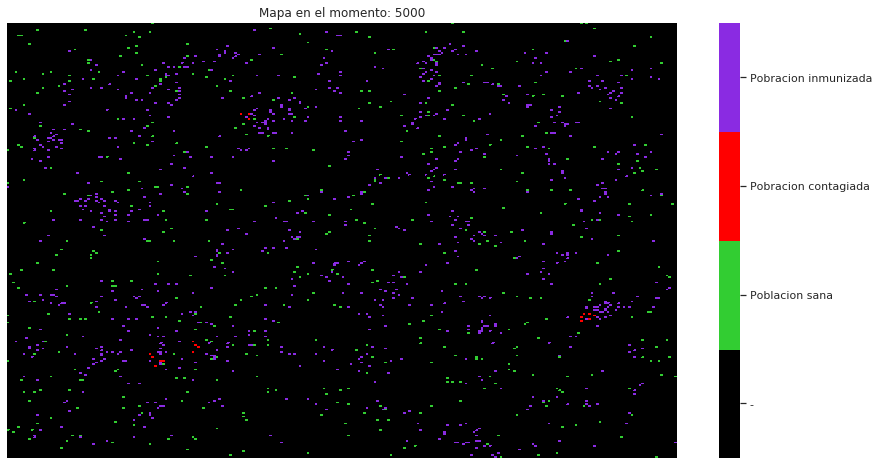

In [31]:
for i in range( len( mapaSimulB ) ):
    plotHeatmapAnimation( mapaSimulB, i )

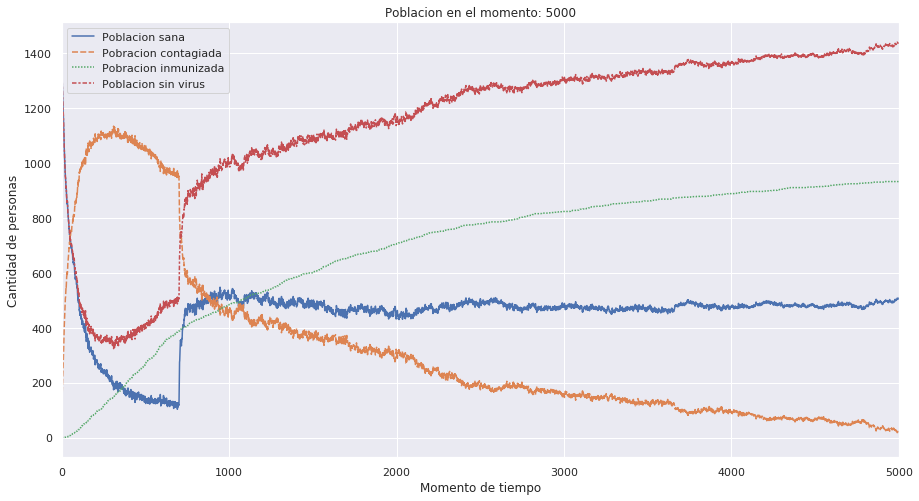

In [32]:
for i in range( len( contagiosSimulB ) ):
    plotDistribAnimation( contagiosSimulB, i )

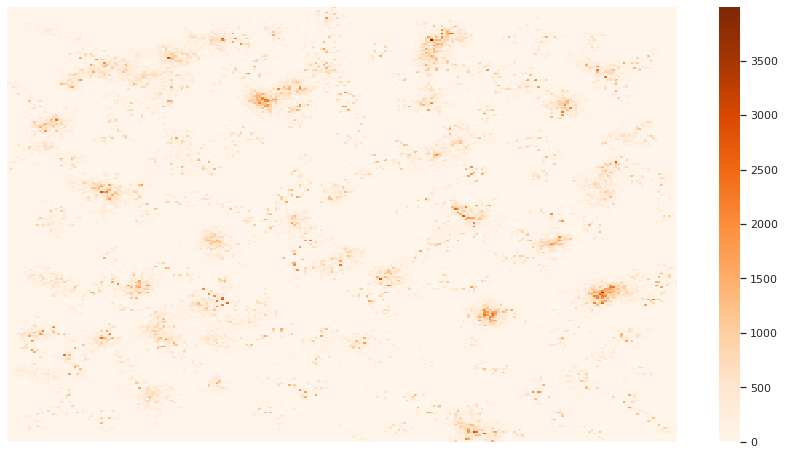

In [ ]:
plotZonaDeContagio( mapaSimulB )

# Simulacion 2

### Estrategia A
Todos los individuos de la población se mueven sin restricciones dentro del área.

Para esto modificaremos unicamente la funcion de como se mueven las personas.

### Supuestos

- La persona enferma y recuperada se mueven todo el tiempo.
- Cuando una persona es infectada, podra infectar a los demas en el proximo instante de tiempo
- Las personas no pueden moverse si hay una persona donde se quieren mover
- Las personas sanas, son las unicas que tienen una restriccion para moverse, cada 1/2/4 turnos
- No hay dos personas superpuestas en la misma posicion

In [12]:
def moverPersonas( tablero, seMueveB, seMueveC, medidasGovierno, recuperacion, pRecuperacion, pInmunizar ):
    """Recorro el tablero moviendo a las personas de manera random y buscando las zonas de contagio"""    
    for i in range(0,len(tablero)):
        for j in range(0,len(tablero[i])):

            if tablero[i][j] == "-":
                continue
            if tablero[i][j] == "B" and not seMueveB :
                continue
            if tablero[i][j] == "C" and not seMueveC :
                continue

            r = np.random.random()
            
            movimiento = randomWalk(r)
            x,y = reemplazar(tablero, i, j, movimiento, tablero[i][j])            
                
                
            if tablero[x][y][0] == 'X':
                    
                instante = int( tablero[x][y][1:] )

                if instante >= 0:
                    contagiarPersonas( tablero, x, y, medidasGovierno )

                instante += 1

                tablero[x][y] = "X"+ str(instante)
                
                if instante >= recuperacion:                    
                    if r < pRecuperacion:
                        darDeAlta( tablero, x, y, pInmunizar )
                

In [13]:
simulacion += 1

os.mkdir(str(simulacion)+" simul") 
os.mkdir(str(simulacion)+" simul/map")
os.mkdir(str(simulacion)+" simul/dist")

sys.stdout = open(str(simulacion)+' simul/'+str(simulacion)+" simul.txt", "w")

metros = 100
tamaño_celda = 0.4
cant_celdas = int( metros/tamaño_celda )

habitantes = 1500               # N Modificable
mapa = generarTablero( cant_celdas, habitantes )

tiempoHastaConfinamiento = 700  # T Modificable
pSeguridad = 0.45               # Modificable por conveniencia - standar 0.15
                                # 0.65 - pSeguridad = pContagio.

intantesParaRecuperacion = 7    # Alpha Modificable
pRecuperacion = 0.5             # Beta Modificable
pInmunizar = 0.005               # Supuesto Modificable 


print("\n----------------------------")
print("--------- VARIABLES --------")
print("----------------------------")

print('habitantes: \t {:f}'.format(habitantes))
print('tiempoHastaConfinamiento: \t {:f}'.format(tiempoHastaConfinamiento))
print('pSeguridad: \t {:f}'.format(pSeguridad))
print('intantesParaRecuperacion: \t {:f}'.format(intantesParaRecuperacion))
print('pRecuperacion: \t {:f}'.format(pRecuperacion))
print('pInmunizar: \t {:f}'.format(pInmunizar))
print("----------------------------\n")


resultsA = realizarSimulacion(mapa, intantesParaRecuperacion, pRecuperacion, pInmunizar, tiempoHastaConfinamiento, pSeguridad )

contagiosSimulA = resultsA[0]
C = resultsA[1]
mapaSimulA = []

print("Iteraciones: {:f}".format(len(contagiosSimulA)), file=sys.stderr )

Iteraciones: 1107.000000


## Sanatizo el set de datos generados
Para afectar lo menor posible en el rendimiento de la generacion de los graficos

In [14]:
for x in C:
    df = pd.DataFrame( data = x )

    df = df.replace(["A","B","C"],"Poblacion sana")

    values = []

    xValues = []
    
    for x in pd.unique(df.values.ravel()):
        if "X" in x:
            xValues.append(x) 

    df = df.replace(xValues,"Pobracion contagiada")
    df = df.replace("R","Pobracion inmunizada")
    
    mapaSimulA.append(df.copy())

## Genero animaciones

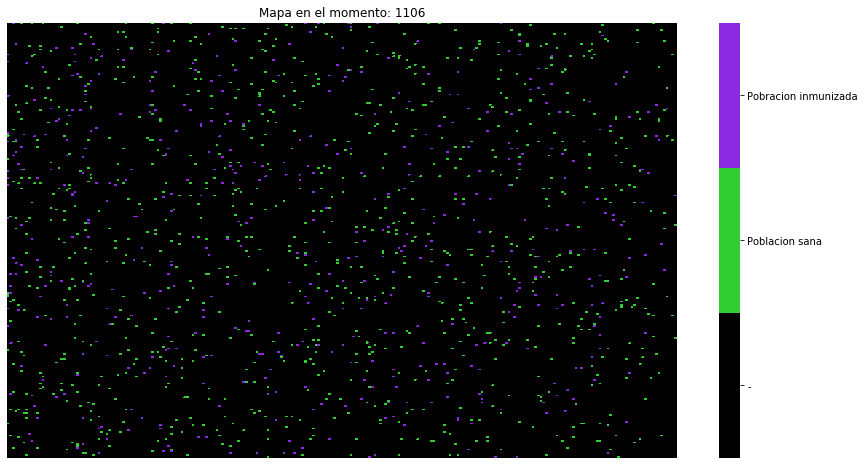

In [15]:
for i in range( len( mapaSimulA ) ):
    plotHeatmapAnimation( mapaSimulA, i )

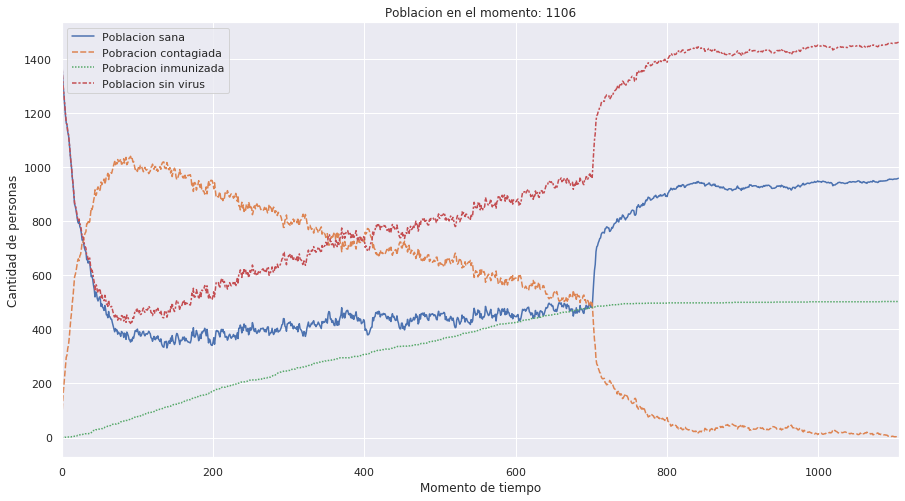

In [16]:
for i in range( len( contagiosSimulA ) ):
    plotDistribAnimation( contagiosSimulA, i )

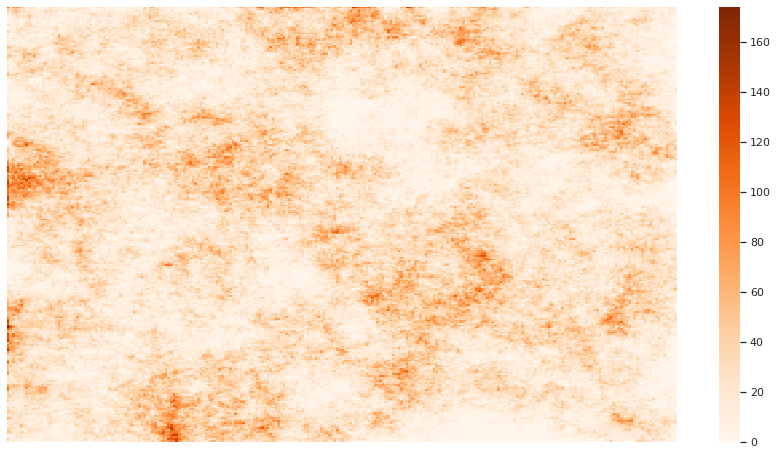

In [19]:
plotZonaDeContagio( mapaSimulA )

# Funciones auxiliares

In [63]:
def plotHeatMap(mapa, iter):
    df = pd.DataFrame( data=mapa )

    df = df.replace(["A","B","C"],"H")

    values = []

    xValues = []
    for x in pd.unique(df.values.ravel()):
        if "X" in x:
            xValues.append(x) 

    df = df.replace(xValues,"X")

    plt.figure(figsize=(20, 10))

    values = sorted(pd.unique(df.values.ravel()))

    value_to_int = {j:i for i,j in enumerate(values)}

    n = len(pd.unique(df.replace(value_to_int).values.ravel()))     

    # discrete colormap (n samples from a given cmap)
    if "R" in values:
        cmap = sns.color_palette(("black","lime","blue","red"), n) 
    else:
        cmap = sns.color_palette(("black","lime","red"), n)
        
    ax = sns.heatmap(df.replace(value_to_int), cmap=cmap) 

    # modify colorbar:
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks( [colorbar.vmin + r / n * (0.5 + i) for i in range(n)] )
    colorbar.set_ticklabels( values )   

    ax.set_title('Mapa en el momento i: ' + str(iter) )
    ax.set(yticks=[],xticks=[])
    plt.show()

In [20]:
def plotResults(lista, iters):
    sns.set_theme()
    plt.figure(figsize=(15, 8))

    df2 = pd.DataFrame(lista)

    df2.columns = ["Habitantes sanos","Habitantes contagiados","Habitantes inmunizados", "Habitantes sin virus"]

    ax = sns.lineplot(data = df2)
    
    ax.set_xlim(0, iters)

    ax.set_title('Mapa en el momento i: ' + str(iters) )                                           
    ax.set_ylabel('Momento de tiempo')                                           
    ax.set_xlabel('Cantidad de personas')
    clear_output(wait=True)
